# Kaggle prerequisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

# Importing the libraries

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import shutil
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from keras.models import model_from_json

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import accuracy_score

from keras.preprocessing import image


#Downloading and Unzipping the datasets

In [ ]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [00:08<00:00, 271MB/s]
100% 2.06G/2.06G [00:08<00:00, 254MB/s]


In [ ]:
!mkdir destination1

In [ ]:
!unzip /content/chest-xray-covid19-pneumonia.zip -d destination1

#Splitting into test, train and calidation sets

In [ ]:
make_dir ='/content/destination1/Data'
root_dir = '/content/destination1/Data/train'
classes_dir = ['COVID19','NORMAL','PNEUMONIA']

val_ratio = 0.1

for cls in classes_dir:

  os.makedirs(make_dir +'/val/' + cls)


    # Creating partitions of the data after shuffeling
  src = root_dir + '/'+ cls # Folder to copy images from

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))

  # moving images

  for name in val_FileNames:
    shutil.move(name, make_dir +'/val/' + cls)


Total images:  460
Training:  414
Validation:  46
Total images:  1266
Training:  1139
Validation:  127
Total images:  3418
Training:  3076
Validation:  342


#Image Augmentation and preprocessing

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/destination1/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 4629 images belonging to 3 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/destination1/Data/val',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 515 images belonging to 3 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_set = val_datagen.flow_from_directory('/content/destination1/Data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1288 images belonging to 3 classes.


# Building the CNN

### Initialising the CNN

In [ ]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


In [ ]:
model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
filepath = '/content/best_Model_weights.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='auto')

In [ ]:
results = model.fit(x=training_set, validation_data= val_set, epochs=20,callbacks=checkpoint)

Epoch 1/20
145/145 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7829
Epoch 1: val_accuracy improved from -inf to 0.91615, saving model to /content/best_Model_weights.h5
145/145 [==============================] - 200s 1s/step - loss: 0.5398 - accuracy: 0.7829 - val_loss: 0.2208 - val_accuracy: 0.9161
Epoch 2/20
145/145 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8864
Epoch 2: val_accuracy improved from 0.91615 to 0.92391, saving model to /content/best_Model_weights.h5
145/145 [==============================] - 183s 1s/step - loss: 0.3020 - accuracy: 0.8864 - val_loss: 0.2265 - val_accuracy: 0.9239
Epoch 3/20
145/145 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.9013
Epoch 3: val_accuracy did not improve from 0.92391
145/145 [==============================] - 177s 1s/step - loss: 0.2719 - accuracy: 0.9013 - val_loss: 0.2152 - val_accuracy: 0.9177
Epoch 4/20
145/145 [==============================] - ETA: 0s 

#Acc and Loss Plots

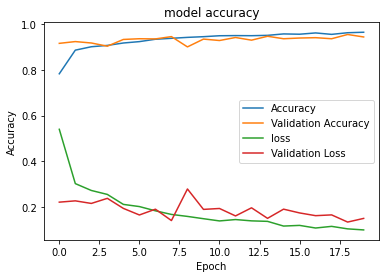

In [ ]:
plt.plot(results.history["accuracy"])
plt.plot(results.history['val_accuracy'])
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

#Grphical Conusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

['COVID19', 'NORMAL', 'PNEUMONIA']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  if __name__ == '__main__':


Confusion Matrix
Normalized confusion matrix


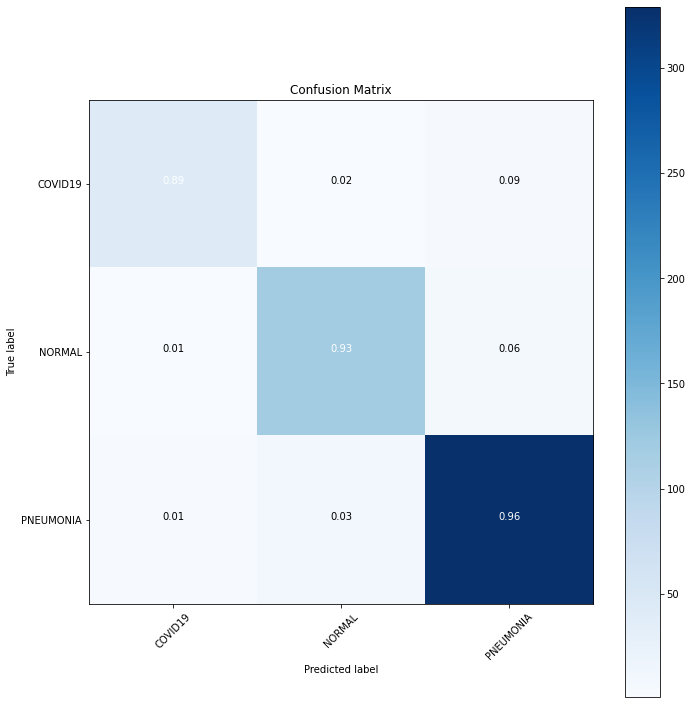

In [ ]:
target_names = []
for key in training_set.class_indices:
    target_names.append(key)

print(target_names)
Y_pred = model.predict_generator(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')

cm = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [ ]:
Y_pred

array([[9.9778336e-01, 1.0386487e-03, 1.1780311e-03],
       [4.2474377e-01, 1.4697751e-02, 5.6055850e-01],
       [9.9907446e-01, 7.8825012e-04, 1.3732204e-04],
       ...,
       [1.9547067e-04, 1.8808758e-02, 9.8099583e-01],
       [2.5146347e-04, 8.8566735e-02, 9.1118175e-01],
       [1.2165539e-06, 3.0274901e-03, 9.9697125e-01]], dtype=float32)

In [ ]:
cm

array([[ 41,   1,   4],
       [  1, 118,   8],
       [  3,  10, 329]])

In [ ]:
y_pred

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,

#Classification Report

In [ ]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

In [ ]:
class_labels = list(test_set.class_indices.keys())   

In [ ]:
confusion_matrix(test_set.classes, predicted_classes)

array([[ 41,   1,   4],
       [  1, 118,   8],
       [  3,  10, 329]])

In [ ]:
predictions

array([[9.9778336e-01, 1.0386487e-03, 1.1780311e-03],
       [4.2474377e-01, 1.4697751e-02, 5.6055850e-01],
       [9.9907446e-01, 7.8825012e-04, 1.3732204e-04],
       ...,
       [1.9547067e-04, 1.8808758e-02, 9.8099583e-01],
       [2.5146347e-04, 8.8566735e-02, 9.1118175e-01],
       [1.2165539e-06, 3.0274901e-03, 9.9697125e-01]], dtype=float32)

In [ ]:
predicted_classes

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 2,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0,

In [ ]:
print(np.trace(confusion_matrix(test_set.classes, predicted_classes)))
accuracy_score(test_set.classes, predicted_classes)

488


0.9475728155339805

In [ ]:
print('Classification Report: ')
report = classification_report(test_set.classes, predicted_classes, target_names=class_labels)
print(report) 

Classification Report: 
              precision    recall  f1-score   support

     COVID19       0.91      0.89      0.90        46
      NORMAL       0.91      0.93      0.92       127
   PNEUMONIA       0.96      0.96      0.96       342

    accuracy                           0.95       515
   macro avg       0.93      0.93      0.93       515
weighted avg       0.95      0.95      0.95       515



In [ ]:
training_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [ ]:
# evaluate the model on test data
score = model.evaluate(test_set, verbose=2)
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

65/65 - 13s - loss: 0.1287 - accuracy: 0.9476 - 13s/epoch - 194ms/step
accuracy: 94.76%


# Making a single prediction

In [ ]:
test_image = image.load_img('/content/COVID19(463).jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
# predicted_classes= np.argmax(model.predict(test_image), axis=1)

result = model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
  prediction = 'COVID19'
elif result[0][1] ==1:
  prediction = 'NORMAL'
elif result[0][2] ==1:
  prediction = 'PNEUMONIA'

In [ ]:
print(result)

[[0. 1. 0.]]
